In [1]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import jaccard_score, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import prepare, model

In [4]:
# Load train, target and test datasets

X_train = pd.read_csv('train_features.csv', index_col=0)
Y_train = pd.read_csv('train_targets_scored.csv', index_col=0)
X_test = pd.read_csv('test_features.csv', index_col=0)

# Load submission sample
sample = pd.read_csv('sample_submission.csv', index_col=0)

# Print their shapes
X_train.shape, Y_train.shape, X_test.shape, sample.shape # Correct

((23814, 875), (23814, 206), (3982, 875), (3982, 206))

In [3]:
# Take a look at X_train
X_train.head()

,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
sig_id,,,,,,,,,,,,,,,,,,,,,
id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [4]:
# Take a look at Y_train
Y_train.head()

,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
sig_id,,,,,,,,,,,,,,,,,,,,,
id_000644bb2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_000779bfc,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_000a6266a,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_0015fd391,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_001626bd3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Take a look at X_test
X_test.head()

,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
sig_id,,,,,,,,,,,,,,,,,,,,,
id_0004d9e33,trt_cp,24,D1,-0.5458,0.1306,-0.5135,0.4408,1.5500,-0.1644,-0.2140,...,0.0981,0.7978,-0.1430,-0.2067,-0.2303,-0.1193,0.0210,-0.0502,0.1510,-0.7750
id_001897cda,trt_cp,72,D1,-0.1829,0.2320,1.2080,-0.4522,-0.3652,-0.3319,-1.8820,...,-0.1190,-0.1852,-1.0310,-1.3670,-0.3690,-0.5382,0.0359,-0.4764,-1.3810,-0.7300
id_002429b5b,ctl_vehicle,24,D1,0.1852,-0.1404,-0.3911,0.1310,-1.4380,0.2455,-0.3390,...,-0.2261,0.3370,-1.3840,0.8604,-1.9530,-1.0140,0.8662,1.0160,0.4924,-0.1942
id_00276f245,trt_cp,24,D2,0.4828,0.1955,0.3825,0.4244,-0.5855,-1.2020,0.5998,...,0.1260,0.1570,-0.1784,-1.1200,-0.4325,-0.9005,0.8131,-0.1305,0.5645,-0.5809
id_0027f1083,trt_cp,48,D1,-0.3979,-1.2680,1.9130,0.2057,-0.5864,-0.0166,0.5128,...,0.4965,0.7578,-0.1580,1.0510,0.5742,1.0900,-0.2962,-0.5313,0.9931,1.8380


## Baseline Model 1  OVR with LR as estimator

### Data Preparation

In [27]:
# Create a mask for treated samples for train
mask = (X_train.cp_type != 'ctl_vehicle')
mask.shape

# Remove controls in X_train
X_train = X_train[mask]

# Remove controls in Y_train
Y_train = Y_train[mask]

# Print the shape of X and Y train
print(X_train.shape)
print(Y_train.shape)

# Create a mask for treated samples for train
mask = (X_test.cp_type != 'ctl_vehicle')
mask.shape

# Remove controls in X_test
X_test = X_test[mask]

# Print the shape of X and Y test
print(X_test.shape)

# Remove controls in sample
sample = sample[mask]

# Print the shape of the submission sample
sample.shape

# Remove the condition columns in X_train and _test

remove_cols = ['cp_type', 'cp_time', 'cp_dose']

# Remove controls in X_train
X_train.drop(columns=remove_cols, inplace=True)

# Remove controls in X_test
X_test.drop(columns=remove_cols, inplace=True)

# Print the shape of X and Y train
print(X_train.shape)
print(X_test.shape) 

(23814,)

**Takeaways**: Build helper function

### Independent models for the 206 labels
- OneVsRestClassifier with LogisticRegression as estimator

In [39]:
# Convert all the dataset to np.assy

X_train = X_train.values
Y_train = Y_train.values
X_test = X_test.values

# Print out the dtypes of X_ and Y_
type(X_train), type(Y_train), type(X_test)

In [46]:
# Create a scaler object
scaler = StandardScaler()

In [47]:
# Scale the dataset
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [52]:
# Fit an independent logistic regression model for each class using the OneVsRestClassifier wrapper.

base_lr = LogisticRegression(max_iter=10000) # Create a lr object and change the max_iter to 10000

ovr = OneVsRestClassifier(base_lr) # Create a ovr object using lr

In [53]:
# fit on train
ovr.fit(X_train_scaled, Y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=10000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [79]:
# Predict Y
Y_pred_ovr = ovr.predict(X_test_scaled)

In [80]:
# Convert predicted Y in a submission format

df_sub = pd.DataFrame(Y_pred_ovr, 
                      index=sample.index, 
                      columns = sample.columns) # Don't remove the controls

# Print the shape of the df_sub
print(df_sub.shape)

# Quick view of df_sub
df_sub.head()

(3624, 206)


,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
sig_id,,,,,,,,,,,,,,,,,,,,,
id_0004d9e33,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_001897cda,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_00276f245,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_0027f1083,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_006fc47b8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [84]:
# Compute the counts for each drug target

df_sub.sum(axis=0).sort_values(ascending=False)

nfkb_inhibitor                           161
proteasome_inhibitor                     142
egfr_inhibitor                            44
tubulin_inhibitor                         44
adrenergic_receptor_agonist               41
                                        ... 
lxr_agonist                                0
mdm_inhibitor                              0
mek_inhibitor                              0
mineralocorticoid_receptor_antagonist      0
5-alpha_reductase_inhibitor                0
Length: 206, dtype: int64

### Baseline Model 2 : OVR with LR as estimator
- The strategy consists in fitting one classifier per class. For each classifier, the class is fitted against all the other classes.
- It also supports multilabel classification. To use this feature, feed the classifier an indicator matrix, in which cell [i, j] indicates the presence of label j in sample i.

In [6]:
# Prepare scaled train and test datasets for modeling
scaler, X_train_scaled, X_test_scaled = prepare.prep_moa_v1(X_train, X_test)

# Print scaler and the shapes of the datasts
scaler, X_train_scaled.shape, X_test_scaled.shape

(MinMaxScaler(copy=True, feature_range=(0, 1)), (23814, 876), (3982, 876))

In [7]:
# Take a look at X_train_scaled
X_train_scaled.head()

,cp_type_trt_cp,cp_time_48,cp_time_72,cp_dose_D2,g-0_scaled,g-1_scaled,g-2_scaled,g-3_scaled,g-4_scaled,g-5_scaled,...,c-90_scaled,c-91_scaled,c-92_scaled,c-93_scaled,c-94_scaled,c-95_scaled,c-96_scaled,c-97_scaled,c-98_scaled,c-99_scaled
sig_id,,,,,,,,,,,,,,,,,,,,,
id_000644bb2,1,0,0,0,0.423838,0.584141,0.510115,0.336117,0.377213,0.520079,...,0.731125,0.734842,0.776018,0.776133,0.713523,0.831778,0.710989,0.790305,0.791709,0.754625
id_000779bfc,1,0,1,0,0.360169,0.570314,0.541622,0.378697,0.451341,0.608766,...,0.680468,0.770365,0.751835,0.737202,0.748942,0.818628,0.751736,0.783357,0.809069,0.777769
id_000a6266a,1,1,0,0,0.395862,0.586368,0.613905,0.370146,0.387116,0.650330,...,0.659251,0.671225,0.761851,0.737151,0.631120,0.755627,0.692951,0.756832,0.655328,0.774582
id_0015fd391,1,1,0,0,0.322259,0.509271,0.509095,0.407976,0.637241,0.531796,...,0.561589,0.670193,0.313779,0.634157,0.664640,0.679881,0.620437,0.705788,0.733155,0.665310
id_001626bd3,1,0,1,1,0.334403,0.495184,0.580266,0.418171,0.475716,0.530934,...,0.711081,0.716676,0.765922,0.814137,0.767607,0.756743,0.748567,0.796077,0.733842,0.775987


In [8]:
# Take a look at X_test_scaled
X_test_scaled.head()

,cp_type_trt_cp,cp_time_48,cp_time_72,cp_dose_D2,g-0_scaled,g-1_scaled,g-2_scaled,g-3_scaled,g-4_scaled,g-5_scaled,...,c-90_scaled,c-91_scaled,c-92_scaled,c-93_scaled,c-94_scaled,c-95_scaled,c-96_scaled,c-97_scaled,c-98_scaled,c-99_scaled
sig_id,,,,,,,,,,,,,,,,,,,,,
id_0004d9e33,1,0,0,0,0.320196,0.544506,0.494816,0.402475,0.483780,0.569124,...,0.717755,0.773481,0.707762,0.720307,0.710679,0.771086,0.742021,0.769870,0.774235,0.668236
id_001897cda,1,0,1,0,0.343589,0.553916,0.593975,0.346656,0.366779,0.559432,...,0.702324,0.703066,0.644001,0.634966,0.700589,0.738396,0.743125,0.736893,0.657387,0.671496
id_002429b5b,0,0,0,0,0.367318,0.519358,0.501866,0.383110,0.301240,0.592842,...,0.694712,0.740473,0.618654,0.798794,0.585364,0.701264,0.804606,0.852368,0.800275,0.710308
id_00276f245,1,0,0,1,0.386502,0.550529,0.546426,0.401450,0.353320,0.509085,...,0.719738,0.727579,0.705220,0.653133,0.695970,0.710122,0.800674,0.763657,0.805774,0.682296
id_0027f1083,1,1,0,0,0.329730,0.414718,0.634583,0.387780,0.353265,0.577676,...,0.746073,0.770616,0.706685,0.812813,0.769201,0.865460,0.718534,0.732645,0.838464,0.857515


In [11]:
# Convert all the dataset to np.assy
X_train_scaled = X_train_scaled.values
Y_train = Y_train.values
X_test_scaled = X_test_scaled.values

# Print out the dtypes of X_ and Y_
type(X_train_scaled), type(Y_train), type(X_test_scaled)

(numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [13]:
# Create the LogisticRegression as the estimator
base_lr = LogisticRegression(max_iter=1000)

# Create a OneVsRest classifier
ovr = OneVsRestClassifier(base_lr)

In [14]:
# Fit on train
ovr.fit(X_train_scaled, Y_train) # Took 13 mins to complete

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [87]:
ovr.estimators_[:5]

[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 

In [89]:
ovr.n_classes_

206

In [91]:
ovr.multilabel_

True

In [66]:
# Predict Y
Y_pred_ovrlr = ovr.predict(X_test_scaled)

# Print the shape
Y_pred_ovrlr.shape

(3982, 206)

In [67]:
# Convert predicted Y in a submission format
sub_ovrlr = pd.DataFrame(Y_pred_ovrlr, index=sample.index, columns = sample.columns)

# Print the shape
print(sub_ovrlr.shape)

# Quick view of df_sub
sub_ovrlr.head()

(3982, 206)


,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
sig_id,,,,,,,,,,,,,,,,,,,,,
id_0004d9e33,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_001897cda,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_002429b5b,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_00276f245,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_0027f1083,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
# How many ids have more than 1 moa annotations?
sub_ovrlr[(sub_moclr.sum(axis=1) > 1)].sum(axis=1) # 169

sig_id
id_02072e865    2
id_07d981850    2
id_09415477c    2
id_0a77c28d0    3
id_0be3355d6    3
               ..
id_faade4732    2
id_fb082adbd    2
id_fbdcbf21b    3
id_fcb6dfb60    2
id_fd272822d    2
Length: 169, dtype: int64

In [68]:
# Compute the counts for each moa annotation
sub_ovrlr.sum(axis=0).sort_values(ascending=False)

nfkb_inhibitor                           142
proteasome_inhibitor                     141
tubulin_inhibitor                         47
glucocorticoid_receptor_agonist           40
egfr_inhibitor                            31
                                        ... 
mineralocorticoid_receptor_antagonist      0
membrane_integrity_inhibitor               0
mek_inhibitor                              0
mdm_inhibitor                              0
5-alpha_reductase_inhibitor                0
Length: 206, dtype: int64

### Model: MO with LR as estimator
- Multioutput classification support can be added to any classifier with MultiOutputClassifier.
- This strategy consists of fitting one classifier per target. 
- ? It is thus comparable to running n_classes binary classification tasks, for example with sklearn.multioutput.MultiOutputClassifier.
- ? This approach treats each label independently whereas multilabel classifiers may treat the multiple classes simultaneously, accounting for correlated behavior among them.

In [36]:
from sklearn.multioutput import MultiOutputClassifier

In [39]:
# Create the LogisticRegression as the estimator
base_lr = LogisticRegression(max_iter=1000)

# Create a multioutput classifier
moc = MultiOutputClassifier(base_lr, n_jobs=2)

In [40]:
# Fit on train
moc.fit(X_train_scaled, Y_train) # Took 18 mins to complete. 

MultiOutputClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                   dual=False,
                                                   fit_intercept=True,
                                                   intercept_scaling=1,
                                                   l1_ratio=None, max_iter=1000,
                                                   multi_class='auto',
                                                   n_jobs=None, penalty='l2',
                                                   random_state=None,
                                                   solver='lbfgs', tol=0.0001,
                                                   verbose=0,
                                                   warm_start=False),
                      n_jobs=2)

In [69]:
# Predict Y
Y_pred_moclr = moc.predict(X_test_scaled)

# Print the shape
Y_pred_moclr.shape

(3982, 206)

In [70]:
# Convert predicted Y in a submission format

sub_moclr = pd.DataFrame(Y_pred_moclr, 
                         index=sample.index, 
                         columns = sample.columns)

# Print the shape of the df_sub
print(sub_moclr.shape)

# Quick view of df_sub
sub_moclr.head()

(3982, 206)


,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
sig_id,,,,,,,,,,,,,,,,,,,,,
id_0004d9e33,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_001897cda,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_002429b5b,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_00276f245,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_0027f1083,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
sub_moclr[(sub_moclr.sum(axis=1) > 1)].sum(axis=1)

sig_id
id_02072e865    2
id_07d981850    2
id_09415477c    2
id_0a77c28d0    3
id_0be3355d6    3
               ..
id_faade4732    2
id_fb082adbd    2
id_fbdcbf21b    3
id_fcb6dfb60    2
id_fd272822d    2
Length: 169, dtype: int64

In [71]:
# Compute the counts for each drug target
sub_moclr.sum(axis=0).sort_values(ascending=False)

nfkb_inhibitor                           142
proteasome_inhibitor                     141
tubulin_inhibitor                         47
glucocorticoid_receptor_agonist           40
egfr_inhibitor                            31
                                        ... 
mineralocorticoid_receptor_antagonist      0
membrane_integrity_inhibitor               0
mek_inhibitor                              0
mdm_inhibitor                              0
5-alpha_reductase_inhibitor                0
Length: 206, dtype: int64

In [77]:
# Are the model's predictions the same as the baseline?
(sub_ovrlr != sub_moclr).any().any()

False

**Takeaways**
1. (moc + lr) returns exactly the same lableling as the baseline model 2 (ovr + lr). 
2. (moc + lr) took longer time than baseline model 2. 
3. moc doesn't have the predit_proba

### How to choose the optimal order for Classifier Chain?
- Based on annotation counts

In [6]:
# Load the Y, the indicator matrix
targets = pd.read_csv('train_targets_scored.csv', index_col=0)

In [91]:
# Compute annotation counts and list top 10
targets.sum(axis=0).sort_values(ascending=False).head(10)

nfkb_inhibitor                    832
proteasome_inhibitor              726
cyclooxygenase_inhibitor          435
dopamine_receptor_antagonist      424
serotonin_receptor_antagonist     404
dna_inhibitor                     402
glutamate_receptor_antagonist     367
adrenergic_receptor_antagonist    360
cdk_inhibitor                     340
egfr_inhibitor                    336
dtype: int64

- Based on which annotation has the highest dependents. 

In [12]:
# Load the dependent pairs
chi2 = pd.read_csv('targets_chi2_dependent.csv', index_col=0)

In [25]:
# Take a look
print(chi2.shape)
chi2.head()

(8906, 3)


,target1,target2,p_chi2
0,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,1.702697e-05
1,5-alpha_reductase_inhibitor,acat_inhibitor,2.223030e-04
4,5-alpha_reductase_inhibitor,acetylcholinesterase_inhibitor,4.933117e-02
5,5-alpha_reductase_inhibitor,adenosine_receptor_agonist,1.858284e-02
7,5-alpha_reductase_inhibitor,adenylyl_cyclase_activator,1.079028e-07


In [43]:
# Compute the counts of dependents of target1
chi2_target1 = chi2.groupby('target1').size().sort_index()

# Rename the index to 'target'
chi2_target1.rename_axis('target', inplace=True)
chi2_target1 # 201 targets total

target
11-beta-hsd1_inhibitor                   142
5-alpha_reductase_inhibitor              149
acat_inhibitor                           118
acetylcholine_receptor_agonist            21
acetylcholine_receptor_antagonist          9
                                        ... 
trpv_antagonist                            1
tyrosine_kinase_inhibitor                  1
ubiquitin_specific_protease_inhibitor      4
vitamin_b                                  2
vitamin_d_receptor_agonist                 1
Length: 201, dtype: int64

In [93]:
chi2_target1['histamine_receptor_antagonist']

2

In [44]:
# Compute the counts of dependents of target2
chi2_target2 = chi2.groupby('target2').size().sort_index()

# Rename the index to 'target'
chi2_target2.rename_axis('target', inplace=True)
chi2_target2 # 200 targets total

target
11-beta-hsd1_inhibitor                     1
acat_inhibitor                             2
acetylcholinesterase_inhibitor             2
adenosine_receptor_agonist                 2
adenylyl_cyclase_activator                 6
                                        ... 
ubiquitin_specific_protease_inhibitor    177
vegfr_inhibitor                           34
vitamin_b                                108
vitamin_d_receptor_agonist                81
wnt_inhibitor                            103
Length: 200, dtype: int64

In [66]:
# Append the two Series above together to one dataframe
chi2_target = pd.DataFrame(chi2_target1).reset_index().append(pd.DataFrame(chi2_target2).reset_index(), 
                                                              ignore_index=True)

# Rename the column name
chi2_target.rename(columns={0: 'dep_counts'}, inplace=True)

# Print the shape of the df
chi2_target.shape

(401, 2)

In [82]:
# Final list of target by counts of dependents
target_dep_counts = chi2_target.groupby('target').sum().sort_values(by='dep_counts', ascending=False)
target_dep_counts.head()

,dep_counts
target,
erbb2_inhibitor,205
atp-sensitive_potassium_channel_antagonist,205
steroid,181
atm_kinase_inhibitor,181
elastase_inhibitor,181


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb39b967950>]],
      dtype=object)

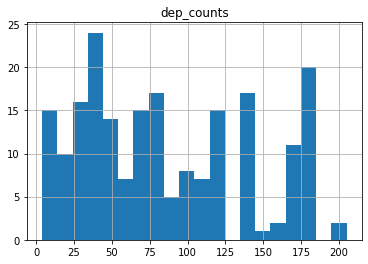

In [90]:
# Viz dependent counts

target_dep_counts.hist(bins=20)

**Takeaways**:
Currenly, two approaches are considered to determine the order for classifier chain. I decide to use the dependent counts as the reference, because it indicates the degree of influence of a single annotation. 

### Which classifier is the best estimator? 

In [7]:
# Load the data set
df = pd.read_csv('screen_estimator.csv', index_col=0)

# Prepare the data set
scaler, train_scaled, validate_scaled, test_scaled = prepare.prep_screen_estimator(df)

# Print the scaler and the shape of the data
scaler, train_scaled.shape, validate_scaled.shape, test_scaled.shape

(MinMaxScaler(copy=True, feature_range=(0, 1)),
 (17145, 877),
 (4287, 877),
 (2382, 877))

In [8]:
# Take a look at train_scaled
train_scaled.head()

,nfkb_inhibitor,cp_type_trt_cp,cp_time_48,cp_time_72,cp_dose_D2,g-0_scaled,g-1_scaled,g-2_scaled,g-3_scaled,g-4_scaled,...,c-90_scaled,c-91_scaled,c-92_scaled,c-93_scaled,c-94_scaled,c-95_scaled,c-96_scaled,c-97_scaled,c-98_scaled,c-99_scaled
sig_id,,,,,,,,,,,,,,,,,,,,,
id_53c3ae622,0,0,0,1,1,0.357964,0.451095,0.314994,0.284661,0.462661,...,0.760971,0.722529,0.688770,0.799750,0.747261,0.788169,0.762680,0.803008,0.802387,0.722658
id_e58576cb3,0,1,1,0,0,0.366148,0.522884,0.449916,0.291974,0.355468,...,0.731509,0.769871,0.773943,0.740880,0.740634,0.778024,0.778094,0.716353,0.775753,0.704310
id_67b0c958a,0,1,0,1,1,0.384150,0.430865,0.410821,0.397256,0.454975,...,0.793447,0.656060,0.822000,0.449838,0.763934,0.703012,0.842745,0.876553,0.689009,0.661101
id_1c1d59613,0,1,0,0,0,0.358619,0.511043,0.451419,0.414177,0.285496,...,0.725147,0.734799,0.682638,0.766144,0.714294,0.697518,0.790418,0.782147,0.694264,0.823760
id_93905b6e8,0,0,1,0,0,0.260700,0.443365,0.366667,0.500375,0.321530,...,0.738375,0.763840,0.789388,0.878714,0.757874,0.797971,0.795828,0.846761,0.758424,0.843173


In [9]:
# Create X and y (scaled)

X_train = train_scaled.iloc[:,1:]
X_validate = validate_scaled.iloc[:,1:]
X_test = test_scaled.iloc[:,1:]

y_train = train_scaled.loc[:, 'nfkb_inhibitor']
y_validate = validate_scaled.loc[:, 'nfkb_inhibitor']
y_test = test_scaled.loc[:, 'nfkb_inhibitor']

### Model on Train

In [10]:
# Import Libraries

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [11]:
# Take a look at X_train
X_train.head()

,cp_type_trt_cp,cp_time_48,cp_time_72,cp_dose_D2,g-0_scaled,g-1_scaled,g-2_scaled,g-3_scaled,g-4_scaled,g-5_scaled,...,c-90_scaled,c-91_scaled,c-92_scaled,c-93_scaled,c-94_scaled,c-95_scaled,c-96_scaled,c-97_scaled,c-98_scaled,c-99_scaled
sig_id,,,,,,,,,,,,,,,,,,,,,
id_53c3ae622,0,0,1,1,0.357964,0.451095,0.314994,0.284661,0.462661,0.606785,...,0.760971,0.722529,0.688770,0.799750,0.747261,0.788169,0.762680,0.803008,0.802387,0.722658
id_e58576cb3,1,1,0,0,0.366148,0.522884,0.449916,0.291974,0.355468,0.571693,...,0.731509,0.769871,0.773943,0.740880,0.740634,0.778024,0.778094,0.716353,0.775753,0.704310
id_67b0c958a,1,0,1,1,0.384150,0.430865,0.410821,0.397256,0.454975,0.614434,...,0.793447,0.656060,0.822000,0.449838,0.763934,0.703012,0.842745,0.876553,0.689009,0.661101
id_1c1d59613,1,0,0,0,0.358619,0.511043,0.451419,0.414177,0.285496,0.562459,...,0.725147,0.734799,0.682638,0.766144,0.714294,0.697518,0.790418,0.782147,0.694264,0.823760
id_93905b6e8,0,1,0,0,0.260700,0.443365,0.366667,0.500375,0.321530,0.558471,...,0.738375,0.763840,0.789388,0.878714,0.757874,0.797971,0.795828,0.846761,0.758424,0.843173


In [12]:
# Take a look at y_train
y_train.head()

sig_id
id_53c3ae622    0
id_e58576cb3    0
id_67b0c958a    0
id_1c1d59613    0
id_93905b6e8    0
Name: nfkb_inhibitor, dtype: int64

In [13]:
# Baseline accuracy
y_train.value_counts(normalize=True) # baseline accuracy 0.965 ? too high # 599 '1'

0    0.965063
1    0.034937
Name: nfkb_inhibitor, dtype: float64

In [14]:
eval_df = pd.DataFrame(columns = ['model_type', 'accuracy'])
eval_df

,model_type,accuracy


In [12]:
# Logistic Regression

lr = LogisticRegression(C=1, random_state=123)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_train)

d = model.estimator_report('Logistic Regression', y_train, y_pred)
eval_df = eval_df.append(d, ignore_index=True)
eval_df

,model_type,accuracy,precision,recall
0,Logistic Regression,0.995217,0.988658,0.873122


In [13]:
# Decision Tree

clf = DecisionTreeClassifier(max_depth=5, random_state=123)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)

d = model.estimator_report('Decision Tree', y_train, y_pred)
eval_df = eval_df.append(d, ignore_index=True)
eval_df

,model_type,accuracy,precision,recall
0,Logistic Regression,0.995217,0.988658,0.873122
1,Decision Tree,0.995217,0.992381,0.869783


In [14]:
# Random Forest

rf = RandomForestClassifier(n_estimators=100, 
                            max_depth=3, 
                            min_samples_split=2, 
                            min_samples_leaf=5, 
                            random_state=123)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_train)

d = model.estimator_report('Random Forest', y_train, y_pred)
eval_df = eval_df.append(d, ignore_index=True)
eval_df

,model_type,accuracy,precision,recall
0,Logistic Regression,0.995217,0.988658,0.873122
1,Decision Tree,0.995217,0.992381,0.869783
2,Random Forest,0.993293,0.935252,0.868114


In [ ]:
# KNN

knn = KNeighborsClassifier(n_neighbors=3, weights='uniform')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_train) # Took 8.5 mins. 

In [16]:
d = model.estimator_report('KNN', y_train, y_pred)
eval_df = eval_df.append(d, ignore_index=True)
eval_df

,model_type,accuracy,precision,recall
0,Logistic Regression,0.995217,0.988658,0.873122
1,Decision Tree,0.995217,0.992381,0.869783
2,Random Forest,0.993293,0.935252,0.868114
3,KNN,0.993992,0.949275,0.874791


In [17]:
# Linear SVM

from sklearn.svm import SVC

clf = SVC(kernel="linear", C=0.025)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)

d = model.estimator_report('Linear SVM', y_train, y_pred)
eval_df = eval_df.append(d, ignore_index=True)
eval_df

,model_type,accuracy,precision,recall
0,Logistic Regression,0.995217,0.988658,0.873122
1,Decision Tree,0.995217,0.992381,0.869783
2,Random Forest,0.993293,0.935252,0.868114
3,KNN,0.993992,0.949275,0.874791
4,Linear SVM,0.994692,0.979245,0.866444


In [18]:
# RBF SVM  

clf = SVC(gamma=2, C=1, random_state=123)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train) # Took about 22 mins. 

d = model.estimator_report('RBF SVM', y_train, y_pred)
eval_df = eval_df.append(d, ignore_index=True)
eval_df

,model_type,accuracy,precision,recall
0,Logistic Regression,0.995217,0.988658,0.873122
1,Decision Tree,0.995217,0.992381,0.869783
2,Random Forest,0.993293,0.935252,0.868114
3,KNN,0.993992,0.949275,0.874791
4,Linear SVM,0.994692,0.979245,0.866444
5,RBF SVM,0.999358,1.000000,0.981636


In [19]:
# Print out the confusion matrx for RBF SVM
confusion_matrix(y_train, y_pred)

array([[16546,     0],
       [   11,   588]])

In [ ]:
# Gaussian Process # No resuls after 1 h running, so abandonded for sure. 

# from sklearn.gaussian_process import GaussianProcessClassifier
# from sklearn.gaussian_process.kernels import RBF

# clf = GaussianProcessClassifier(1.0 * RBF(1.0))
# clf.fit(X_train, y_train)
# y_pred = clf.predict(X_train) 

# d = model.estimator_report('Gaussian Process', y_train, y_pred)
# eval_df = eval_df.append(d, ignore_index=True)
# eval_df

In [17]:
# Neutal Net

clf = MLPClassifier(random_state=123)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)

d = model.estimator_report('Neural Net', 'train', y_train, y_pred)
eval_df = eval_df.append(d, ignore_index=True)
eval_df

,model_type,accuracy,data_type,precision,recall
0,Neural Net,0.995451,train,0.99619,0.873122


In [19]:
# Neutal Net-2

clf = MLPClassifier(alpha=1, random_state=123)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)

d = model.estimator_report('Neural Net-2', 'train', y_train, y_pred)
eval_df = eval_df.append(d, ignore_index=True)
eval_df

,model_type,accuracy,data_type,precision,recall
0,Neural Net,0.995451,train,0.996190,0.873122
1,Neural Net-2,0.988043,train,0.802147,0.873122


In [20]:
# Print out the confusion matrx for Neural Net-2
confusion_matrix(y_train, y_pred)

array([[16417,   129],
       [   76,   523]])

In [21]:
# AdaBoostCalssifier

from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(random_state=123)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)

d = model.estimator_report('AdaBoost', 'train', y_train, y_pred)
eval_df = eval_df.append(d, ignore_index=True)
eval_df

,model_type,accuracy,data_type,precision,recall
0,Neural Net,0.995451,train,0.996190,0.873122
1,Neural Net-2,0.988043,train,0.802147,0.873122
2,AdaBoost,0.993234,train,0.960000,0.841402


In [22]:
# Naive Bayes

from sklearn.naive_bayes import GaussianNB

clf =  GaussianNB(random_state=123)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)

d = model.estimator_report('Naive Bayes', 'train', y_train, y_pred)
eval_df = eval_df.append(d, ignore_index=True)
eval_df

,model_type,accuracy,data_type,precision,recall
0,Neural Net,0.995451,train,0.996190,0.873122
1,Neural Net-2,0.988043,train,0.802147,0.873122
2,AdaBoost,0.993234,train,0.960000,0.841402
3,Naive Bayes,0.949315,train,0.397572,0.874791


In [23]:
# Print out the confusion matrx for Naive Bayes
confusion_matrix(y_train, y_pred)

array([[15752,   794],
       [   75,   524]])

In [24]:
# QDA

clf =  QuadraticDiscriminantAnalysis()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)

d = model.estimator_report('QDA', 'train', y_train, y_pred)
eval_df = eval_df.append(d, ignore_index=True)
eval_df

,model_type,accuracy,data_type,precision,recall
0,Neural Net,0.995451,train,0.996190,0.873122
1,Neural Net-2,0.988043,train,0.802147,0.873122
2,AdaBoost,0.993234,train,0.960000,0.841402
3,Naive Bayes,0.949315,train,0.397572,0.874791
4,QDA,0.995217,train,1.000000,0.863105


In [25]:
# Print out the confusion matrx for QDA
confusion_matrix(y_train, y_pred)

array([[16546,     0],
       [   82,   517]])

In [26]:
# Drop data type column so can be appended
eval_df.drop(columns=['data_type'], inplace=True)

In [92]:
# Read the evaluation from the output

eval_cb = pd.read_clipboard()


# Reset index and drop column 'level_0' and KNN
eval_cb.reset_index(inplace=True)
eval_cb.drop(columns='level_0', index=3, inplace=True) 
eval_cb

,level_1,model_type,accuracy,precision,recall
0,Logistic,Regression,0.995217,0.988658,0.873122
1,Decision,Tree,0.995217,0.992381,0.869783
2,Random,Forest,0.993293,0.935252,0.868114
4,Linear,SVM,0.994692,0.979245,0.866444
5,RBF,SVM,0.999358,1.000000,0.981636


In [45]:
df.model_type = df['level_1'].str.cat(df['model_type'], sep=' ')
df.drop(columns='level_1', inplace=True)
df

,model_type,accuracy,precision,recall
0,Logistic Regression,0.995217,0.988658,0.873122
1,Decision Tree,0.995217,0.992381,0.869783
2,Random Forest,0.993293,0.935252,0.868114
4,Linear SVM,0.994692,0.979245,0.866444
5,RBF SVM,0.999358,1.000000,0.981636


In [105]:
# Create eval_final by merge two evals

eval_final = eval_df.append(df, ignore_index=True)
eval_final

,model_type,accuracy,precision,recall
0,Neural Net,0.995451,0.996190,0.873122
1,Neural Net-2,0.988043,0.802147,0.873122
2,AdaBoost,0.993234,0.960000,0.841402
3,Naive Bayes,0.949315,0.397572,0.874791
4,QDA,0.995217,1.000000,0.863105
5,Logistic Regression,0.995217,0.988658,0.873122
6,Decision Tree,0.995217,0.992381,0.869783
7,Random Forest,0.993293,0.935252,0.868114
8,Linear SVM,0.994692,0.979245,0.866444
9,RBF SVM,0.999358,1.000000,0.981636


In [106]:
# Add KNN back to the final eval

eval_final = eval_final.append({'model_type': 'KNN', 
                                'accuracy': 0.993992, 
                                'precision': 0.949275, 
                                'recall': 0.874791}, ignore_index=True)

eval_final

,model_type,accuracy,precision,recall
0,Neural Net,0.995451,0.996190,0.873122
1,Neural Net-2,0.988043,0.802147,0.873122
2,AdaBoost,0.993234,0.960000,0.841402
3,Naive Bayes,0.949315,0.397572,0.874791
4,QDA,0.995217,1.000000,0.863105
5,Logistic Regression,0.995217,0.988658,0.873122
6,Decision Tree,0.995217,0.992381,0.869783
7,Random Forest,0.993293,0.935252,0.868114
8,Linear SVM,0.994692,0.979245,0.866444
9,RBF SVM,0.999358,1.000000,0.981636


In [109]:
# Add baseline to the final eval
# Compute the y_pred for baseline

y_pred_b = [0]*y_train.shape[0]

# Compute the metrics for baseline
d = model.estimator_report('baseline', 'train', y_train, y_pred_b)

# Drop key data type
d = {'model_type': 'baseline', 
     'accuracy': 0.9650627004957714,
     'precision': 'nan',
     'recall': 0.0}

# Append d to eval_final
eval_final = eval_final.append(d, ignore_index=True)

# Print eval_final
eval_final

,model_type,accuracy,precision,recall
0,Neural Net,0.995451,0.99619,0.873122
1,Neural Net-2,0.988043,0.802147,0.873122
2,AdaBoost,0.993234,0.96,0.841402
3,Naive Bayes,0.949315,0.397572,0.874791
4,QDA,0.995217,1,0.863105
5,Logistic Regression,0.995217,0.988658,0.873122
6,Decision Tree,0.995217,0.992381,0.869783
7,Random Forest,0.993293,0.935252,0.868114
8,Linear SVM,0.994692,0.979245,0.866444
9,RBF SVM,0.999358,1,0.981636


In [111]:
# Convert to .csv
# eval_final.to_csv('eval_final_train.csv')

In [113]:
# Rank by accuracy
eval_final.sort_values('accuracy', ascending=False)

,model_type,accuracy,precision,recall
9,RBF SVM,0.999358,1,0.981636
0,Neural Net,0.995451,0.99619,0.873122
4,QDA,0.995217,1,0.863105
5,Logistic Regression,0.995217,0.988658,0.873122
6,Decision Tree,0.995217,0.992381,0.869783
8,Linear SVM,0.994692,0.979245,0.866444
10,KNN,0.993992,0.949275,0.874791
7,Random Forest,0.993293,0.935252,0.868114
2,AdaBoost,0.993234,0.96,0.841402
1,Neural Net-2,0.988043,0.802147,0.873122


In [114]:
# Rank by recall
eval_final.sort_values('recall', ascending=False)

,model_type,accuracy,precision,recall
9,RBF SVM,0.999358,1,0.981636
3,Naive Bayes,0.949315,0.397572,0.874791
10,KNN,0.993992,0.949275,0.874791
5,Logistic Regression,0.995217,0.988658,0.873122
0,Neural Net,0.995451,0.99619,0.873122
1,Neural Net-2,0.988043,0.802147,0.873122
6,Decision Tree,0.995217,0.992381,0.869783
7,Random Forest,0.993293,0.935252,0.868114
8,Linear SVM,0.994692,0.979245,0.866444
4,QDA,0.995217,1,0.863105


In [118]:
# Rank by precision
eval_final.drop(index=11).sort_values('precision', ascending=False)

,model_type,accuracy,precision,recall
4,QDA,0.995217,1,0.863105
9,RBF SVM,0.999358,1,0.981636
0,Neural Net,0.995451,0.99619,0.873122
6,Decision Tree,0.995217,0.992381,0.869783
5,Logistic Regression,0.995217,0.988658,0.873122
8,Linear SVM,0.994692,0.979245,0.866444
2,AdaBoost,0.993234,0.96,0.841402
10,KNN,0.993992,0.949275,0.874791
7,Random Forest,0.993293,0.935252,0.868114
1,Neural Net-2,0.988043,0.802147,0.873122


### Selec top 4 and model on validate

In [136]:
# Reset eval_df
eval_df = pd.DataFrame(columns = ['model_type', 'data_type', 'accuracy', 'precision', 'recall'])
eval_df

,model_type,data_type,accuracy,precision,recall


In [135]:
# Repeat QDA on train

clf =  QuadraticDiscriminantAnalysis()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)

d = model.estimator_report('QDA', 'train', y_train, y_pred)
d # Pass check

{'model_type': 'QDA',
 'data_type': 'train',
 'accuracy': 0.995217264508603,
 'precision': 1.0,
 'recall': 0.8631051752921536}

In [137]:
# QDA on validate

# Confirm classifier
print(clf)

# Make prediction
y_pred = clf.predict(X_validate)
d = model.estimator_report('QDA', 'validate', y_validate, y_pred)
eval_df = eval_df.append(d, ignore_index=True)
eval_df

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)


,model_type,data_type,accuracy,precision,recall
0,QDA,validate,0.96501,NaN,0.0


In [138]:
# Print the confusion matrix of QDA on validate
confusion_matrix(y_validate, y_pred)

array([[4137,    0],
       [ 150,    0]])

In [139]:
# Repeat Neutal Net on train

clf = MLPClassifier(random_state=123)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)

d = model.estimator_report('Neural Net', 'train', y_train, y_pred)
d

{'model_type': 'Neural Net',
 'data_type': 'train',
 'accuracy': 0.9954505686789151,
 'precision': 0.9961904761904762,
 'recall': 0.8731218697829716}

In [140]:
# Neutral Net on validate

# Confirm classifier
print(clf)

# Make prediction
y_pred = clf.predict(X_validate)
d = model.estimator_report('Neutral Net', 'validate', y_validate, y_pred)
eval_df = eval_df.append(d, ignore_index=True)
eval_df

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=123, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


,model_type,data_type,accuracy,precision,recall
0,QDA,validate,0.965010,NaN,0.000000
1,Neutral Net,validate,0.994635,0.992248,0.853333


In [141]:
# Print the confusion matrix
confusion_matrix(y_validate, y_pred)

array([[4136,    1],
       [  22,  128]])